# DAT200 CA5 2022

Kaggle username: Arterx

### Imports

In [39]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import r2_score, confusion_matrix, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from scipy import stats
from mlxtend.plotting import scatterplotmatrix

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

### Reading data

In [2]:
raw_data = pd.read_pickle('train.pkl') # Naming the train data "raw_data"
test_data = pd.read_pickle('test.pkl') # Naming the test data "test_data"

# To inspect the data with excel
raw_data.to_csv("train_unpickled.csv")
test_data.to_csv("test_unpickled.csv")

### Data exploration and visualisation

In [3]:
raw_data = raw_data.replace('missing', np.NaN)
test_data = test_data.replace('missing', np.NaN)

In [4]:
print(raw_data.isna().sum()) # Checking how many NaN values there are

Season                                 39
Year                                   37
Month                                  31
Hour                                   50
Holiday                                30
Weekday                                36
Working day                            34
Weather situation                      27
Temperature (normalized)               36
Feels-like temperature (normalized)    24
Humidity (normalized)                  30
Windspeed                              34
Rental bikes count                      0
dtype: int64


In [5]:
print(f'\nThe shape of the training data is:{raw_data.shape}\n')
print(f'\nThe shape of the test data is:{test_data.shape}\n')


The shape of the training data is:(12165, 13)


The shape of the test data is:(5214, 12)



### Data cleaning

In [6]:
dummies = pd.get_dummies(raw_data[['Season', 'Weather situation']], drop_first=True) # Converting 'season' and weather situation into numerical values
enc_data = pd.concat([raw_data, dummies], axis=1) # Merging / concatenating two dataframes
enc_data = enc_data._get_numeric_data()
enc_data

,Year,Month,Hour,Holiday,Weekday,Working day,Temperature (normalized),Feels-like temperature (normalized),Humidity (normalized),Windspeed,Rental bikes count,Season_Spring,Season_Summer,Season_Winter,"Weather situation_Heavy rain, heavy snow or thunderstorm",Weather situation_Light snow or light rain,Weather situation_Misty and/or cloudy
0,1.0,6.0,18.0,0.0,1.0,1.0,0.76,0.6667,0.27,0.4478,791,0,1,0,0,0,0
1,1.0,10.0,11.0,0.0,3.0,1.0,0.36,0.3485,0.66,0.2239,189,0,0,0,0,0,1
2,0.0,6.0,22.0,0.0,6.0,0.0,0.64,0.6212,0.57,0.2239,190,1,0,0,0,0,0
3,0.0,3.0,21.0,0.0,2.0,1.0,0.42,0.4242,0.54,0.2836,87,1,0,0,0,0,1
4,1.0,11.0,5.0,0.0,2.0,1.0,0.34,0.3333,0.66,0.1343,34,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12160,0.0,9.0,16.0,0.0,3.0,1.0,0.76,0.6970,0.52,0.2836,277,0,1,0,0,0,0
12161,0.0,5.0,8.0,0.0,1.0,1.0,0.56,0.5303,0.73,0.2985,394,1,0,0,0,0,0
12162,0.0,5.0,1.0,0.0,2.0,1.0,0.46,0.4545,0.59,0.0896,15,1,0,0,0,0,0
12163,0.0,4.0,16.0,0.0,2.0,1.0,0.48,0.4697,0.77,0.3881,99,1,0,0,0,0,1


In [7]:
# Encoding and imputing the test data aswell
dummies2 = pd.get_dummies(test_data[['Season', 'Weather situation']], drop_first=True) # Converting 'season' and weather situation into numerical values

enc_test = pd.concat([test_data, dummies2], axis=1) # Merging / concatenating two dataframes
enc_test = enc_test._get_numeric_data()
enc_test

,Year,Month,Hour,Holiday,Weekday,Working day,Temperature (normalized),Feels-like temperature (normalized),Humidity (normalized),Windspeed,Season_Spring,Season_Summer,Season_Winter,"Weather situation_Heavy rain, heavy snow or thunderstorm",Weather situation_Light snow or light rain,Weather situation_Misty and/or cloudy
0,1,6,19,0,5,1,0.70,0.6364,0.42,0.1642,1,0,0,0,0,0
1,1,9,3,0,4,1,0.44,0.4394,0.77,0.0000,0,1,0,0,0,0
2,0,4,14,0,1,1,0.58,0.5455,0.49,0.1940,1,0,0,0,0,1
3,0,5,18,0,3,1,0.72,0.6667,0.58,0.2239,1,0,0,0,0,0
4,0,4,3,0,3,1,0.40,0.4091,0.94,0.3284,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5209,0,7,20,0,1,1,0.78,0.7424,0.59,0.2239,0,1,0,0,0,0
5210,0,2,22,0,6,0,0.30,0.2576,0.28,0.4925,0,0,1,0,0,0
5211,0,9,22,0,0,0,0.54,0.5152,0.68,0.0896,0,1,0,0,0,1
5212,1,8,0,0,3,1,0.62,0.5758,0.83,0.1045,0,1,0,0,0,0


### Imputing data 

In [8]:
imp = SimpleImputer(missing_values=np.NaN, strategy='median')
imp_data = imp.fit(enc_data.values)
imp_data = imp.transform(enc_data.values)
imp_df = pd.DataFrame(imp_data, columns=enc_data.columns)

imp_df.head() # Checking if the imputer worked

,Year,Month,Hour,Holiday,Weekday,Working day,Temperature (normalized),Feels-like temperature (normalized),Humidity (normalized),Windspeed,Rental bikes count,Season_Spring,Season_Summer,Season_Winter,"Weather situation_Heavy rain, heavy snow or thunderstorm",Weather situation_Light snow or light rain,Weather situation_Misty and/or cloudy
0,1.0,6.0,18.0,0.0,1.0,1.0,0.76,0.6667,0.27,0.4478,791.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,10.0,11.0,0.0,3.0,1.0,0.36,0.3485,0.66,0.2239,189.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,6.0,22.0,0.0,6.0,0.0,0.64,0.6212,0.57,0.2239,190.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,3.0,21.0,0.0,2.0,1.0,0.42,0.4242,0.54,0.2836,87.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,11.0,5.0,0.0,2.0,1.0,0.34,0.3333,0.66,0.1343,34.0,0.0,0.0,0.0,0.0,0.0,1.0


In [50]:
imp_df.info() # Checking the data types, should all be float numbers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12165 entries, 0 to 12164
Data columns (total 17 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Year                                                      12165 non-null  float64
 1   Month                                                     12165 non-null  float64
 2   Hour                                                      12165 non-null  float64
 3   Holiday                                                   12165 non-null  float64
 4   Weekday                                                   12165 non-null  float64
 5   Working day                                               12165 non-null  float64
 6   Temperature (normalized)                                  12165 non-null  float64
 7   Feels-like temperature (normalized)                       12165 non-null  float64
 8   Humidity (normal

In [9]:
imp2 = SimpleImputer(missing_values=np.NaN, strategy='median')
imp_test = imp2.fit(enc_test.values)
imp_test = imp2.transform(enc_test.values)
imp_test_df = pd.DataFrame(imp_test, columns=enc_test.columns)

imp_test_df.head() # Checking if the imputer worked

,Year,Month,Hour,Holiday,Weekday,Working day,Temperature (normalized),Feels-like temperature (normalized),Humidity (normalized),Windspeed,Season_Spring,Season_Summer,Season_Winter,"Weather situation_Heavy rain, heavy snow or thunderstorm",Weather situation_Light snow or light rain,Weather situation_Misty and/or cloudy
0,1.0,6.0,19.0,0.0,5.0,1.0,0.70,0.6364,0.42,0.1642,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,9.0,3.0,0.0,4.0,1.0,0.44,0.4394,0.77,0.0000,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,4.0,14.0,0.0,1.0,1.0,0.58,0.5455,0.49,0.1940,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,5.0,18.0,0.0,3.0,1.0,0.72,0.6667,0.58,0.2239,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,4.0,3.0,0.0,3.0,1.0,0.40,0.4091,0.94,0.3284,1.0,0.0,0.0,0.0,1.0,0.0


In [48]:
imp_test_df.info() # Checking the data types, should all be float numbers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5214 entries, 0 to 5213
Data columns (total 16 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Year                                                      5214 non-null   float64
 1   Month                                                     5214 non-null   float64
 2   Hour                                                      5214 non-null   float64
 3   Holiday                                                   5214 non-null   float64
 4   Weekday                                                   5214 non-null   float64
 5   Working day                                               5214 non-null   float64
 6   Temperature (normalized)                                  5214 non-null   float64
 7   Feels-like temperature (normalized)                       5214 non-null   float64
 8   Humidity (normaliz

### Data exploration after cleaning

In [11]:
print(imp_df.isna().sum()) # Checking if the NaN values are gone from the training data
print(f'\n{imp_test_df.isna().sum()}\n') # Checking if the NaN values are gone from the test data
print(f'\nThe shape of the imputed training data is: {imp_df.shape}\n')
print(f'\nThe shape of the imputed testing data is: {imp_test_df.shape}\n')

Year                                                        0
Month                                                       0
Hour                                                        0
Holiday                                                     0
Weekday                                                     0
Working day                                                 0
Temperature (normalized)                                    0
Feels-like temperature (normalized)                         0
Humidity (normalized)                                       0
Windspeed                                                   0
Rental bikes count                                          0
Season_Spring                                               0
Season_Summer                                               0
Season_Winter                                               0
Weather situation_Heavy rain, heavy snow or thunderstorm    0
Weather situation_Light snow or light rain                  0
Weather 

#### Preprocessing

In [12]:
X = imp_df.drop(['Rental bikes count'], axis=1)
y = imp_df['Rental bikes count']

#### Plots

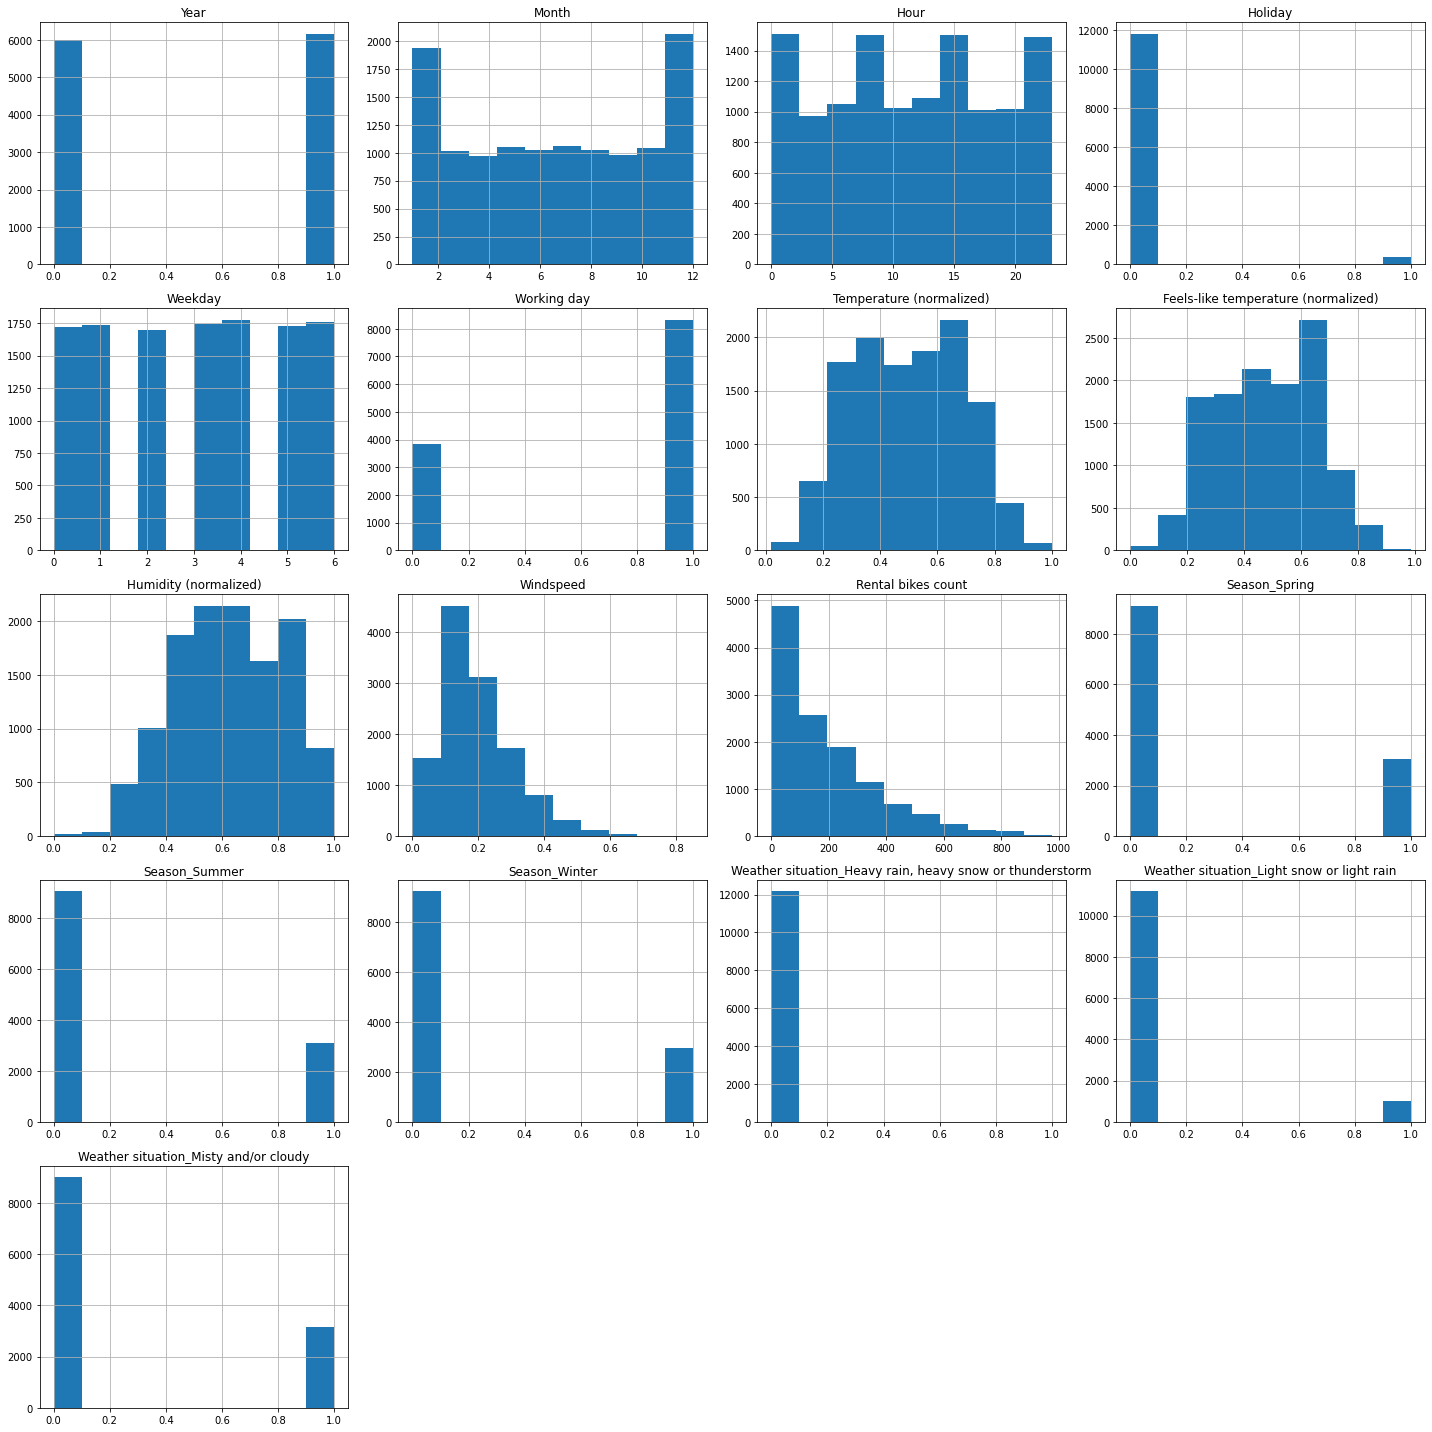

In [13]:
# Histograms

imp_df.hist(figsize=(20, 20)) # Making it big for easier inspection
plt.tight_layout()
plt.show()

As one can see, the bikes are never used during heavy rain, but some times used when there is light snow or misty weather.
Furthermore, one can see a trend where the bikes are mostly used during working days.

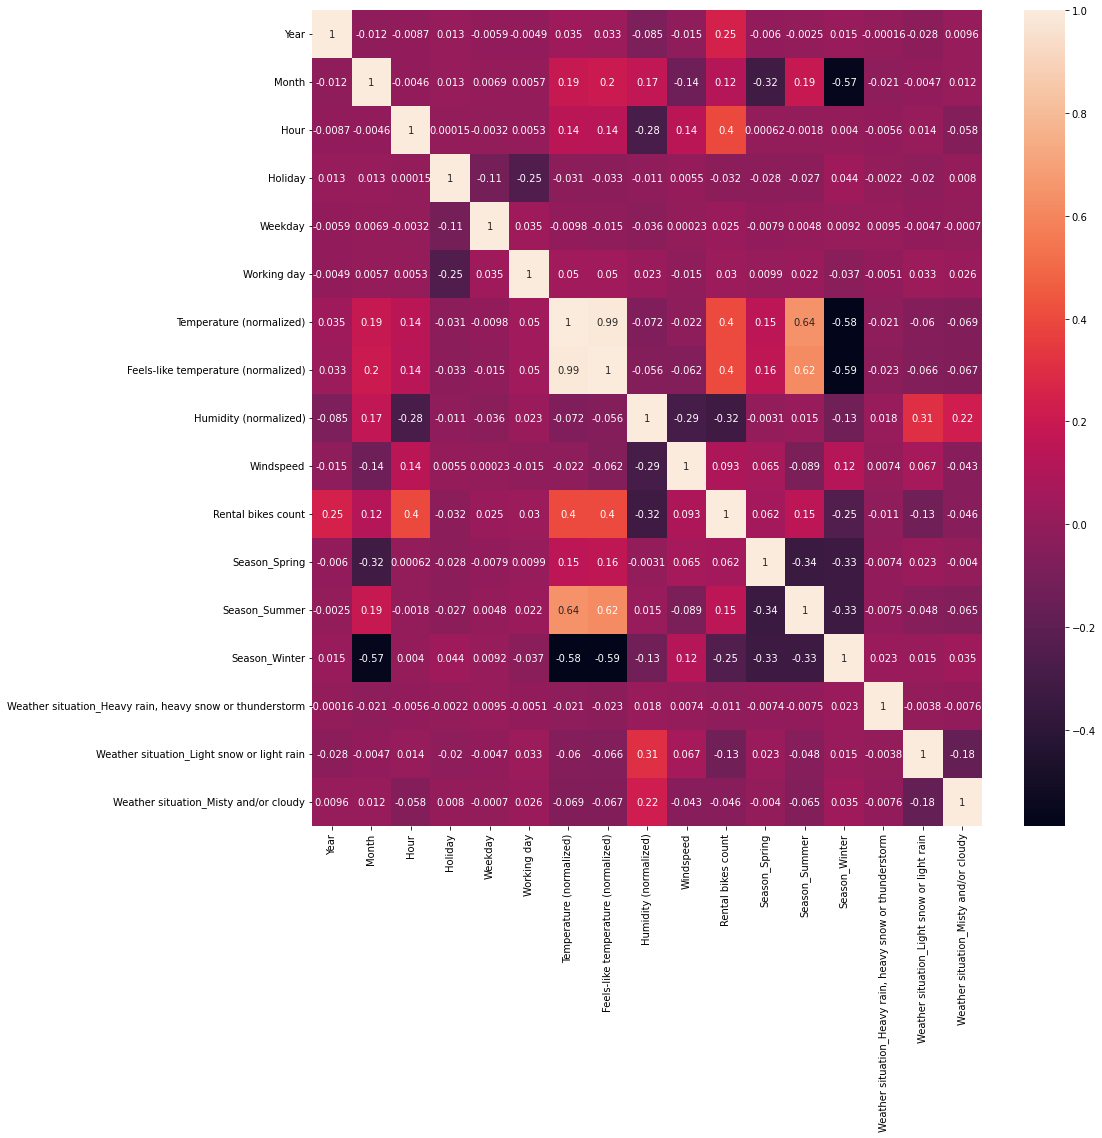

In [14]:
# Correlation matrix

plt.figure(figsize=(15, 15)) # Making it big for easier inspection
corr_matrix = imp_df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

As seen above, Temperature (normalized) correlates with Feels-like temperature (normalized). 
However, both Temperature (normalized) and Feels-like temperature (normalized) inversely correlate with Season_Winter. 
One can also see a trend where there are more bikes used during the summer and less used during the winter.

#### Train test split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8515, 16) (3650, 16) (8515,) (3650,)


#### Scaling

### Modelling

#### Data pipeline with regression model

In [16]:
gbr_pipe = make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=21))

param_dist = [{'gradientboostingregressor__learning_rate': [0.01, 0.02, 0.05, 0.1],
'gradientboostingregressor__n_estimators':[500],
'gradientboostingregressor__min_samples_leaf': [1, 3, 9],
'gradientboostingregressor__max_depth':[5, 6, 7],
'gradientboostingregressor__max_features':[0.3,0.6,1.0]}]

g_search_gbr = GridSearchCV(estimator=gbr_pipe,
                                     param_grid=param_dist,
                                     scoring='r2',
                                     cv=10, 
                                     n_jobs=-1)

In [17]:
g_search_gbr.fit(X_train, y_train) # Finding the best parameters for GBR

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor(random_state=21))]),
             n_jobs=-1,
             param_grid=[{'gradientboostingregressor__learning_rate': [0.01,
                                                                       0.02,
                                                                       0.05,
                                                                       0.1],
                          'gradientboostingregressor__max_depth': [5, 6, 7],
                          'gradientboostingregressor__max_features': [0.3, 0.6,
                                                                      1.0],
                          'gradientboostingregressor__min_samples_leaf': [1, 3,
                                                                          9],
                        

In [18]:
best_params = g_search_gbr.best_params_
print('The best parameters achieved from the grid search are: ', best_params)

The best parameters achieved from the grid search are:  {'gradientboostingregressor__learning_rate': 0.05, 'gradientboostingregressor__max_depth': 7, 'gradientboostingregressor__max_features': 0.6, 'gradientboostingregressor__min_samples_leaf': 3, 'gradientboostingregressor__n_estimators': 500}


In [19]:
gbr_best =  g_search_gbr.best_estimator_
gbr_best.fit(X, y) # Fitting the best parameters into the model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=7,
                                           max_features=0.6, min_samples_leaf=3,
                                           n_estimators=500,
                                           random_state=21))])

In [20]:
y_pred = gbr_best.predict(imp_test_df)

print('Gradient boosting regressor training data accuracy: {0:.2f}'.format(gbr_best.score(X_train, y_train)))

print('Gradient boosting regressor test data accuracy: {0:.2f}'.format(gbr_best.score(X_test, y_test)))

Gradient boosting regressor training data accuracy: 0.98
Gradient boosting regressor test data accuracy: 0.98


#### Kaggle submission GBR

In [21]:
pred2_df = pd.DataFrame(data=y_pred)
pred2_df.reset_index(level=0, inplace=True)
pred2_df.columns = ['idx', 'Rental bikes count']
pred2_df['Rental bikes count'] = pred2_df['Rental bikes count'].apply(np.int64) # Converting the float values to int

pred2_df.to_csv('Pred2_gbr.csv', index=False, sep=',')

#### Data pipeline with classification model

##### Binning train target values

Can be performed with ex. pandas.qcut or pandas.cut

```python
n_bins = 10
y_train_binned = pd.cut(y_train, n_bins, labels=False) # or
y_train_binned = pd.qcut(y_train, n_bins, labels=False) 
```

In [37]:
# I found out that the accuracy decreased when I used more than 5 bins

n_bins = 5
y_train_binned = pd.cut(y_train, n_bins, labels=False)
y_test_binned = pd.cut(y_test, n_bins, labels=False)

#### Binned Random Forest Pipeline 

In [28]:
forest = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=21))

param_dist = {
    'randomforestclassifier__n_estimators': [50, 100, 200, 300],
    'randomforestclassifier__max_depth': [2, 4, 6, 8, 10],
    'randomforestclassifier__min_samples_leaf': [1, 5, 10],
    'randomforestclassifier__max_features': ['auto', 'sqrt'],
    'randomforestclassifier__bootstrap': [True, False]
}

forest_gs = GridSearchCV(estimator=forest, param_grid=param_dist, scoring='r2', cv=5, n_jobs=-1)

In [29]:
forest_gs.fit(X_train, y_train_binned)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=21))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__bootstrap': [True, False],
                         'randomforestclassifier__max_depth': [2, 4, 6, 8, 10],
                         'randomforestclassifier__max_features': ['auto',
                                                                  'sqrt'],
                         'randomforestclassifier__min_samples_leaf': [1, 5, 10],
                         'randomforestclassifier__n_estimators': [50, 100, 200,
                                                                  300]},
             scoring='r2')

In [30]:
best_params = forest_gs.best_params_

print('The best parameters achieved from the grid search are: ', best_params)

The best parameters achieved from the grid search are:  {'randomforestclassifier__bootstrap': False, 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 50}


In [33]:
forest_best =  forest_gs.best_estimator_
forest_best.fit(X_train, y_train_binned)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        n_estimators=50, random_state=21))])

In [34]:
y_pred = forest_best.predict(imp_test_df)

print('Forest training data accuracy: {0:.2f}'.format(forest_best.score(X_train, y_train_binned)))

print('Forest test data accuracy: {0:.2f}'.format(forest_best.score(X_test, y_test_binned)))

Forest training data accuracy: 0.86
Forest test data accuracy: 0.80


#### Kaggle submission Binned random forest pipeline

In [35]:
pred3_df = pd.DataFrame(data=y_pred)
pred3_df.reset_index(level=0, inplace=True)
pred3_df.columns = ['idx', 'Rental bikes count']
pred3_df['Rental bikes count'] = pred3_df['Rental bikes count'].apply(np.int64) # Converting the float values to int

pred3_df.to_csv('Pred_forest.csv', index=False, sep=',')

I got the best results from using the Gradient Boosting Regressor model. It performed much better than the binned random forest pipeline.